In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler

from helpers import (
    report_model_cv_metrics, 
    report_oversampling_model_cv_metrics
)
from sklearn.metrics import (
    accuracy_score, recall_score, 
    precision_score, f1_score,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("cleaned_case_study_data.csv", dtype={"lead_segment_20_c":"str"})


In [3]:
df[["estimated_income_min_c",
    "estimated_income_max_c",
    "economic_stability_indicator_c",
    "total_liquid_investible_assets_c",
    "atp_value", "affluence_index_value",
    "income_360_value",
    "vantage_score_neighborhood_risk_score_value"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   estimated_income_min_c                       23226 non-null  float64
 1   estimated_income_max_c                       23667 non-null  float64
 2   economic_stability_indicator_c               24466 non-null  float64
 3   total_liquid_investible_assets_c             24226 non-null  float64
 4   atp_value                                    87246 non-null  float64
 5   affluence_index_value                        75459 non-null  float64
 6   income_360_value                             82083 non-null  float64
 7   vantage_score_neighborhood_risk_score_value  87240 non-null  float64
dtypes: float64(8)
memory usage: 6.1 MB


In [4]:
# The 3rd party estimates are often missing. 
# So do initial analysis without these features.

df = df.drop(columns=[
    "estimated_income_min_c",
    "estimated_income_max_c",
    "economic_stability_indicator_c",
    "total_liquid_investible_assets_c",
    "atp_value", "affluence_index_value",
    "income_360_value",
    "vantage_score_neighborhood_risk_score_value"
    ])

In [5]:
# Intially drop those missing data.

df = df.dropna()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88340 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      88340 non-null  int64  
 1   lead_number                     88340 non-null  int64  
 2   apts_in_next_seven_c            88340 non-null  float64
 3   lead_segment_20_c               88340 non-null  object 
 4   distance_to_center              88340 non-null  float64
 5   dental_condition                88340 non-null  object 
 6   has_email                       88340 non-null  int64  
 7   created_date                    88340 non-null  object 
 8   scheduled_time_c                88340 non-null  object 
 9   apt_date_c                      88340 non-null  object 
 10  apt_hour                        88340 non-null  int64  
 11  sched_source                    88340 non-null  object 
 12  prev_no_shows                   

In [7]:
# Split dataset - 80% train and 20% test.

df_train, df_test = train_test_split(df, test_size=0.2, random_state=13)

In [8]:
# Understand the imbalanced distribution of the target.

print(f"Percentage of arrivals: {len(df_train.query('is_arrived == 1')) / len(df_train):.1%}")

Percentage of arrivals: 25.6%


## Start with a Logistic Regression.

Keeping it simple and taking an educated guess at the best features.

In [9]:
# Gather features - transforming categorical and scaling numerical.
# Gather target.

X_categorical = df_train[[
    "dental_condition_consolidated", "has_email", "apt_date_day"
    ]]
X_categorical = pd.get_dummies(X_categorical, drop_first=True)

X_numeric = df_train[[
    "distance_to_center_conslidated", "apt_hour", 
    "days_created_to_scheduling", "num_campaigns"
    ]]
scaler = StandardScaler()
X_numeric = scaler.fit_transform(X_numeric)

X = np.concatenate((X_numeric, X_categorical), axis=1)


y = df_train["is_arrived"]



In [10]:
# Basic logistic regression performance.

print(report_model_cv_metrics(model=LogisticRegression(), X = X, y=y))

Accuracy: 74.8%
Recall: 4.0%
Precision: 60.5%
F1: 7.5%


In [11]:
# Because of imbalance in target, try oversampling.

sample_model = RandomOverSampler(sampling_strategy=0.75, random_state=13)

print(report_oversampling_model_cv_metrics(model=LogisticRegression(), 
                                           X = X, y=y,
                                           sampling_model=sample_model))

NEW percentage of 1's: 42.9%
Accuracy: 69.2%
Recall: 32.6%
Precision: 38.1%
F1: 35.1%


## Build a Random Forest model.

Include more potential features since model will do feature selection.

In [12]:
# Gather features - transform categorical.
# Gather target.

X_categorical = df_train[[
    "lead_segment_20_c", "dental_condition_consolidated", 
    "has_email", "in_market", "created_by_channel",
    "sched_source", "apt_date_day"
    ]]
X_categorical = pd.get_dummies(X_categorical, drop_first=True)

X_numeric = df_train[[
    "apts_in_next_seven_c", "distance_to_center_conslidated", 
    "apt_hour", "num_campaigns",
    "days_created_to_scheduling", "days_created_to_appointment", 
    "days_scheduling_to_appointment"
    ]]

X = pd.merge(X_numeric, X_categorical, left_index=True, right_index=True)


y = df_train["is_arrived"]



In [13]:
# Basic random forest model.
rand_forest = RandomForestClassifier(random_state=13)

print(report_model_cv_metrics(model=rand_forest, X = X, y=y))

Accuracy: 78.0%
Recall: 29.1%
Precision: 65.7%
F1: 40.3%


In [14]:
# Because of imbalance in target, try oversampling again.

sample_model = RandomOverSampler(sampling_strategy=0.75, random_state=13)

print(report_oversampling_model_cv_metrics(model=rand_forest, 
                                           X = X, y=y,
                                           sampling_model=sample_model))

NEW percentage of 1's: 42.9%
Accuracy: 77.7%
Recall: 34.9%
Precision: 61.1%
F1: 44.4%


#### Grid search for some hyperparameter tuning.

In [15]:
rand_forest = RandomForestClassifier(random_state=13)

parameters = {
    "n_estimators": [50, 100],
    "max_features": ["sqrt", "log2", None],
    "max_depth": [None, 20],
    "min_samples_leaf": [1, 7],
    "min_samples_split": [2, 10],
}


rand_forest_grid = GridSearchCV(
    estimator=rand_forest,
    param_grid=parameters,
    scoring="precision", #false pos rather than false neg are the bigger burden. 
    n_jobs=-1,
    cv=2,
    verbose=True
    )

rand_forest_grid.fit(X, y)

print(f"Best Precision Score: {abs(rand_forest_grid.best_score_):.1%}")
print(rand_forest_grid.best_params_)

Fitting 2 folds for each of 48 candidates, totalling 96 fits
Best Precision Score: 73.6%
{'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 100}


In [16]:
# Test out tuned model. 

rand_forest_tuned = RandomForestClassifier(
    n_estimators=100,
    max_features="log2",
    max_depth=20,
    min_samples_leaf=7,
    min_samples_split=2,
    random_state=13
    )


print(report_model_cv_metrics(model=rand_forest_tuned, X = X, y=y))


Accuracy: 78.2%
Recall: 23.6%
Precision: 73.0%
F1: 35.6%


## Build an XG Boost Model.

First compare to previous models and then explore adding 3rd party features since model can handle missing data.

In [17]:
# Gather features - transforming categorical.
# Gather target.

X_categorical = df_train[[
    "lead_segment_20_c", "dental_condition_consolidated", 
    "has_email", "in_market", "created_by_channel",
    "sched_source", "apt_date_day"
    ]]
X_categorical = pd.get_dummies(X_categorical, drop_first=True)

X_numeric = df_train[[
    "apts_in_next_seven_c", "distance_to_center_conslidated", 
    "apt_hour", "num_campaigns",
    "days_created_to_scheduling", "days_created_to_appointment", 
    "days_scheduling_to_appointment"
    ]]

X = pd.merge(X_numeric, X_categorical, left_index=True, right_index=True)


y = df_train["is_arrived"]


In [18]:
# Basic XG Boost model.

xgb_model = XGBClassifier(random_state=13)

print(report_model_cv_metrics(model=xgb_model, X = X, y=y))

Accuracy: 78.8%
Recall: 34.0%
Precision: 66.9%
F1: 45.1%


In [19]:
# XG Boost model utilizing oversampling.

xgb_model = XGBClassifier(random_state=13)

sample_model = RandomOverSampler(sampling_strategy=0.75, random_state=13)

print(report_oversampling_model_cv_metrics(model=xgb_model, 
                                           X = X, y=y,
                                           sampling_model=sample_model))

NEW percentage of 1's: 42.9%
Accuracy: 75.6%
Recall: 51.3%
Precision: 52.4%
F1: 51.8%


#### Try building a model with 3rd party data.

Import the dataset again but this time keep the 3rd party data.

In [20]:
# Import the dataset again to include the 3rd party data.
df_include_party = pd.read_csv("cleaned_case_study_data.csv", dtype={"lead_segment_20_c":"str"})

df_party_train, df_party_test = train_test_split(
    df_include_party, test_size=0.2,random_state=13
    )

In [21]:
# Gather features - transforming categorical.
# Gather target.

X_categorical = df_party_train[[
    "lead_segment_20_c", "dental_condition_consolidated", 
    "has_email", "in_market", "created_by_channel",
    "sched_source", "apt_date_day"
    ]]
X_categorical = pd.get_dummies(X_categorical, drop_first=True)

X_numeric = df_party_train[[
    "apts_in_next_seven_c", "distance_to_center_conslidated", 
    "apt_hour", "num_campaigns",
    "days_created_to_scheduling", "days_created_to_appointment", 
    "days_scheduling_to_appointment",
    "estimated_income_min_c",
    "estimated_income_max_c",
    "economic_stability_indicator_c",
    "total_liquid_investible_assets_c",
    "atp_value", "affluence_index_value",
    "income_360_value",
    "vantage_score_neighborhood_risk_score_value"
    ]]

X_party = pd.merge(X_numeric, X_categorical, left_index=True, right_index=True)


y_party = df_party_train["is_arrived"]

In [22]:
# Basic XG Boost model with 3rd party features.

xgb_model = XGBClassifier(random_state=13)

print(report_model_cv_metrics(model=xgb_model, X = X_party, y=y_party))

Accuracy: 78.5%
Recall: 33.7%
Precision: 66.4%
F1: 44.7%


#### Explore feature importance and do some feature selection.

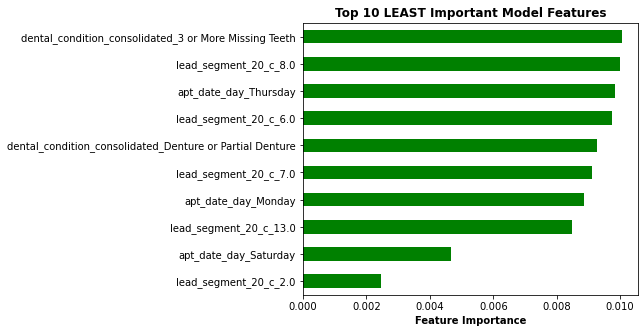

In [23]:
# Fit the model.
xgb_model = XGBClassifier(random_state=13)
xgb_model.fit(X_party, y_party)


# Graph the bottom 10 features (by importance).
fig,ax = plt.subplots(figsize=(6,5))

feat_importances = pd.Series(xgb_model.feature_importances_, index=X_party.columns)
feat_importances.nsmallest(10).sort_values().plot(kind='barh', color="green")

plt.xlabel("Feature Importance", weight="bold")
plt.title("Top 10 LEAST Important Model Features", weight="bold");

In [24]:
# Try dropping dental_condition_consolidated, apt_date_day, and created_by_channel.

X_categorical = df_party_train[[
    "lead_segment_20_c", 
    # "dental_condition_consolidated", 
    "has_email", "in_market", 
    # "created_by_channel", "apt_date_day"
    "sched_source"
    ]]
X_categorical = pd.get_dummies(X_categorical, drop_first=True)

X_numeric = df_party_train[[
    "apts_in_next_seven_c", "distance_to_center_conslidated", 
    "apt_hour", "num_campaigns",
    "days_created_to_scheduling", "days_created_to_appointment", 
    "days_scheduling_to_appointment",
    "estimated_income_min_c",
    "estimated_income_max_c",
    "economic_stability_indicator_c",
    "total_liquid_investible_assets_c",
    "atp_value", "affluence_index_value",
    "income_360_value",
    "vantage_score_neighborhood_risk_score_value"
    ]]

X = pd.merge(X_numeric, X_categorical, left_index=True, right_index=True)

y = df_party_train["is_arrived"]


# Test the model.
xgb_model = XGBClassifier(random_state=13)

print(report_model_cv_metrics(model=xgb_model, X = X, y=y))

Accuracy: 78.3%
Recall: 33.1%
Precision: 66.0%
F1: 44.0%


In [25]:
# Try dropping lead_segment_20_c.

X_categorical = df_party_train[[
    # "lead_segment_20_c", 
    # "dental_condition_consolidated", 
    "has_email", "in_market", 
    # "created_by_channel", "apt_date_day"
    "sched_source"
    ]]
X_categorical = pd.get_dummies(X_categorical, drop_first=True)

X_numeric = df_party_train[[
    "apts_in_next_seven_c", "distance_to_center_conslidated", 
    "apt_hour", "num_campaigns",
    "days_created_to_scheduling", "days_created_to_appointment", 
    "days_scheduling_to_appointment",
    "estimated_income_min_c",
    "estimated_income_max_c",
    "economic_stability_indicator_c",
    "total_liquid_investible_assets_c",
    "atp_value", "affluence_index_value",
    "income_360_value",
    "vantage_score_neighborhood_risk_score_value"
    ]]

X = pd.merge(X_numeric, X_categorical, left_index=True, right_index=True)

y = df_party_train["is_arrived"]


# Test the model.
xgb_model = XGBClassifier(random_state=13)

print(report_model_cv_metrics(model=xgb_model, X = X, y=y))

Accuracy: 78.3%
Recall: 32.9%
Precision: 66.0%
F1: 43.9%


In [26]:
# Try also dropping some of the less important numeric features. 

X_categorical = df_party_train[[
    # "lead_segment_20_c", 
    # "dental_condition_consolidated", 
    "has_email", "in_market", 
    # "created_by_channel", "apt_date_day"
    "sched_source"
    ]]
X_categorical = pd.get_dummies(X_categorical, drop_first=True)

X_numeric = df_party_train[[
    "apts_in_next_seven_c", "distance_to_center_conslidated", 
    # "apt_hour",
    "num_campaigns",
    "days_created_to_scheduling", "days_created_to_appointment", 
    "days_scheduling_to_appointment",
    # "estimated_income_min_c",
    "estimated_income_max_c",
    "economic_stability_indicator_c",
    # "total_liquid_investible_assets_c",
    "atp_value", "affluence_index_value",
    # "income_360_value",
    "vantage_score_neighborhood_risk_score_value"
    ]]

X = pd.merge(X_numeric, X_categorical, left_index=True, right_index=True)

y = df_party_train["is_arrived"]


# Test the model.
xgb_model = XGBClassifier(random_state=13)

print(report_model_cv_metrics(model=xgb_model, X = X, y=y))

Accuracy: 78.4%
Recall: 33.4%
Precision: 66.2%
F1: 44.4%


In [27]:
# Redo the best XG Boost model (that doesn't include 3rd party data) on the full dataset for a fairer comparison.

X_categorical = df_party_train[[
    "lead_segment_20_c", "dental_condition_consolidated", 
    "has_email", "in_market", "created_by_channel",
    "sched_source", "apt_date_day"
    ]]
X_categorical = pd.get_dummies(X_categorical, drop_first=True)

X_numeric = df_party_train[[
    "apts_in_next_seven_c", "distance_to_center_conslidated", 
    "apt_hour", "num_campaigns",
    "days_created_to_scheduling", "days_created_to_appointment", 
    "days_scheduling_to_appointment"
    ]]

X = pd.merge(X_numeric, X_categorical, left_index=True, right_index=True)


y = df_party_train["is_arrived"]

# Test the model.
xgb_model = XGBClassifier(random_state=13)

print(report_model_cv_metrics(model=xgb_model, X = X, y=y))

Accuracy: 78.4%
Recall: 33.4%
Precision: 66.5%
F1: 44.5%


#### Grid search to optimize (some) XG Boost hyperparameters.

In [28]:
# Gather up the final features of interst.

X_categorical = df_party_train[[
    "lead_segment_20_c", "dental_condition_consolidated", 
    "has_email", "in_market", "created_by_channel",
    "sched_source", "apt_date_day"
    ]]
X_categorical = pd.get_dummies(X_categorical, drop_first=True)

X_numeric = df_party_train[[
    "apts_in_next_seven_c", "distance_to_center_conslidated", 
    "apt_hour", "num_campaigns",
    "days_created_to_scheduling", "days_created_to_appointment", 
    "days_scheduling_to_appointment"
    ]]

X = pd.merge(X_numeric, X_categorical, left_index=True, right_index=True)

y = df_party_train["is_arrived"]

In [29]:
xgb_model = XGBClassifier(random_state=13)

parameters = {
    "subsample": [0.75, 1],
    "max_depth": (6, 8, 10),
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.2]
}


xgb_grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=parameters,
    scoring="precision", #false pos rather than false neg are the bigger burden. 
    n_jobs=-1,
    cv=2,
    verbose=True
    )

xgb_grid.fit(X, y)

print(f"Best Precision: {abs(rand_forest_grid.best_score_):.1%}")
print(xgb_grid.best_params_)


Fitting 2 folds for each of 36 candidates, totalling 72 fits
Best Precision: 73.6%
{'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 6, 'subsample': 0.75}


In [31]:
# Tuned XG Boost model.

xgb_model_tuned = XGBClassifier(
    subsample=0.75,
    max_depth=6,
    learning_rate=0.05,
    gamma=0.2,
    random_state=13
    )

print(report_model_cv_metrics(model=xgb_model_tuned, X = X, y=y))


Accuracy: 78.5%
Recall: 29.9%
Precision: 69.7%
F1: 41.8%


## Build Final Model and Assess Performance on Holdout Data.

In [32]:
# Redo the training data to ensure it's correct for final testing.

X_train_categorical = df_party_train[[
    "lead_segment_20_c", "dental_condition_consolidated", 
    "has_email", "in_market", "created_by_channel",
    "sched_source", "apt_date_day"
    ]]
X_train_categorical = pd.get_dummies(X_train_categorical, drop_first=True)

X_train_numeric = df_party_train[[
    "apts_in_next_seven_c", "distance_to_center_conslidated", 
    "apt_hour", "num_campaigns",
    "days_created_to_scheduling", "days_created_to_appointment", 
    "days_scheduling_to_appointment"
    ]]

X_train = pd.merge(X_train_numeric, X_train_categorical, left_index=True, right_index=True)


y_train = df_party_train["is_arrived"]

In [33]:
# Need to prep the test dataset for analysis.

X_test_categorical = df_party_test[[
    "lead_segment_20_c", "dental_condition_consolidated", 
    "has_email", "in_market", "created_by_channel",
    "sched_source", "apt_date_day"
    ]]
X_test_categorical = pd.get_dummies(X_test_categorical, drop_first=True)


X_test_numeric = df_party_test[[
    "apts_in_next_seven_c", "distance_to_center_conslidated", 
    "apt_hour", "num_campaigns",
    "days_created_to_scheduling", "days_created_to_appointment", 
    "days_scheduling_to_appointment"
    ]]

X_test = pd.merge(X_test_numeric, X_test_categorical, left_index=True, right_index=True)

# Have to make sure the same features are included in the train and test datasets.
# First, remove potential extra columns.
need_to_remove = list(set(X_test.columns).difference(set(X_train.columns)))
X_test_categorical = X_test.drop(columns=need_to_remove)
# Next, add any needed columns.
need_to_add = set(X_train.columns).difference(set(X_test.columns))
for col in need_to_add:
    X_test[col] = 0
# Last, make order the same.
X_test = X_test[X_train.columns]


y_test = df_party_test["is_arrived"]


In [34]:
# Fit the model on the full training dataset then predict values from the test data.

final_model = XGBClassifier(random_state=13)
final_model.fit(X_train, y_train)


y_predicted = final_model.predict(X_test)

In [35]:
# Assess model performance on the test data.

print(f"Accuracy: {accuracy_score(y_test, y_predicted):.1%}")
print(f"Recall: {recall_score(y_test, y_predicted):.1%}")
print(f"Precision: {precision_score(y_test, y_predicted):.1%}")
print(f"F1: {f1_score(y_test, y_predicted):.1%}")

Accuracy: 78.5%
Recall: 34.1%
Precision: 67.8%
F1: 45.3%


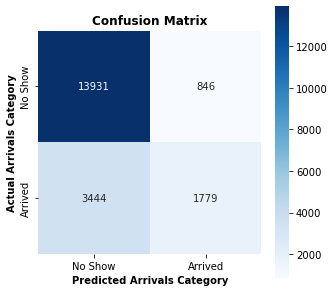

In [36]:
# Create a confusion matrix.

fig,ax = plt.subplots(figsize=(5,5))

confusion = confusion_matrix(y_test, y_predicted)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
            xticklabels=["No Show", "Arrived"],
            yticklabels=["No Show", "Arrived"])

plt.xlabel("Predicted Arrivals Category", weight="bold")
plt.ylabel("Actual Arrivals Category", weight="bold")
plt.title("Confusion Matrix", weight="bold");

In [37]:
print(f"Percentage of ACTUAL arrivals (test data): {len(y_test[y_test == 1]) / len(y_test):.1%}")
print(f"Percentage of PREDICTED arrivals (test data): {len(y_predicted[y_predicted == 1]) / len(y_predicted):.1%}")

Percentage of ACTUAL arrivals (test data): 26.1%
Percentage of PREDICTED arrivals (test data): 13.1%


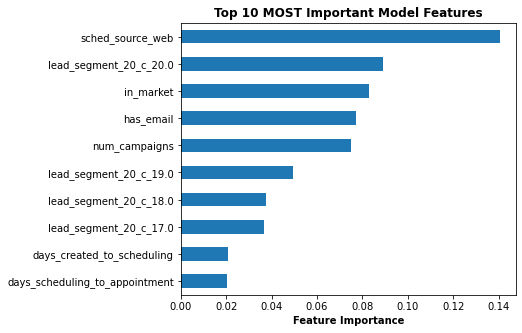

In [38]:
fig,ax = plt.subplots(figsize=(6,5))

feat_importances = pd.Series(final_model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh')

plt.xlabel("Feature Importance", weight="bold")
plt.title("Top 10 MOST Important Model Features", weight="bold");

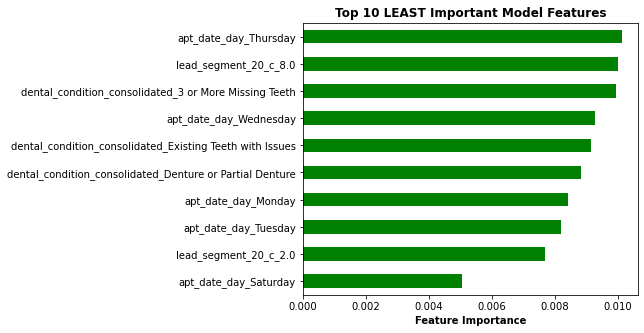

In [39]:
fig,ax = plt.subplots(figsize=(6,5))

feat_importances = pd.Series(final_model.feature_importances_, index=X_test.columns)
feat_importances.nsmallest(10).sort_values().plot(kind='barh', color="green")

plt.xlabel("Feature Importance", weight="bold")
plt.title("Top 10 LEAST Important Model Features", weight="bold");

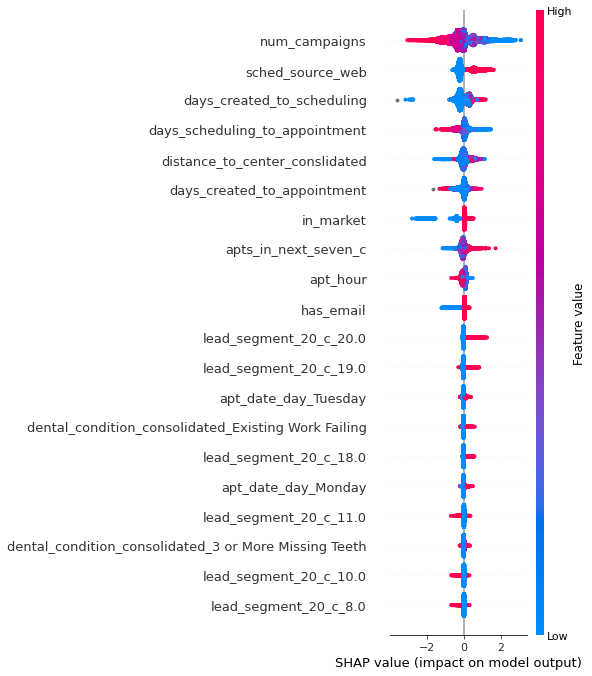

In [43]:
# Explore SHAP values to understand how the features contribute to predictions of attendance.
import shap

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

